In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader


In [2]:
# Assuming you've downloaded the dataset from Kaggle and saved it as 'indian_flood_dataset.csv'
dataset_path = 'IndianFloodInventroy(IFI).csv'
df = pd.read_csv(dataset_path)

# Preprocess the dataset as needed (handle missing values, encode categorical variables, etc.)
# ...

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4738 entries, 0 to 4737
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   UEI                                4738 non-null   object 
 1   Start Date                         4738 non-null   object 
 2   End Date                           4738 non-null   object 
 3   Duration(Days)                     4590 non-null   float64
 4   Main Cause                         4600 non-null   object 
 5   Location                           276 non-null    object 
 6   Districts                          4121 non-null   object 
 7   State                              4175 non-null   object 
 8   Latitude                           325 non-null    float64
 9   Longitude                          325 non-null    float64
 10  Severity                           262 non-null    float64
 11  Area Affected                      262 non-null    float

In [3]:
import networkx as nx
import pandas as pd

def create_graph(data):
    # Assuming your dataset has columns like 'node1', 'node2', 'edge_weight'
    edges = zip(data['node1'], data['node2'], data['edge_weight'])

    graph = nx.Graph()

    # Add nodes and weighted edges to the graph
    graph.add_weighted_edges_from(edges)

    return graph

# Example usage:
# Assuming you have a DataFrame named 'your_data' with columns 'node1', 'node2', 'edge_weight'
your_data = pd.DataFrame({
    'node1': [1, 2, 3],
    'node2': [2, 3, 1],
    'edge_weight': [0.5, 0.8, 0.6]
})

# Create a graph from the data
your_graph = create_graph(your_data)

# Print the graph information
print("Nodes:", your_graph.nodes)
print("Edges:", your_graph.edges)


Nodes: [1, 2, 3]
Edges: [(1, 2), (1, 3), (2, 3)]


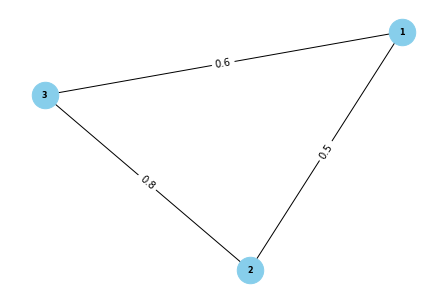

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to create and show the graph
def show_graph(graph):
    pos = nx.spring_layout(graph)  # Layout algorithm, you can choose other layouts based on your preference
    labels = nx.get_edge_attributes(graph, 'weight')

    nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    plt.show()

# Assuming you have already created a graph (e.g., your_graph)
show_graph(your_graph)


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named 'your_data' with columns 'node1', 'node2', 'edge_weight'
# Adjust column names based on your actual dataset

# Features (X)
X = your_data[['node1', 'node2', 'edge_weight']]

# Perform train-test split (80% training, 20% testing)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Train set shape - X:", X_train.shape)
print("Test set shape - X:", X_test.shape)


Train set shape - X: (2, 3)
Test set shape - X: (1, 3)


In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Replace 'your_data' with your actual DataFrame
your_data = pd.DataFrame({
    'node1': [1, 2, 3],
    'node2': [2, 3, 1],
    'edge_weight': [0.5, 0.8, 0.6],
    'target': [0.2, 0.5, 0.8]  # Replace with your actual target variable
})

# Separate features (X) and target variable (y)
X = your_data[['node1', 'node2', 'edge_weight']]
y = your_data['target']

# Perform train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the train and test sets to PyTorch Geometric Data
train_graph = create_graph(X_train)
test_graph = create_graph(X_test)

# Combine node indices from both train and test graphs to ensure all nodes are considered
all_nodes = list(set(train_graph.nodes) | set(test_graph.nodes))

# Create a mapping between original node indices and indices of the identity matrix
node_index_mapping = {node: idx for idx, node in enumerate(all_nodes)}

# Convert the train and test sets to PyTorch Geometric Data with proper node indices
def create_graph_data(graph, node_index_mapping):
    edge_index = torch.tensor([
        [node_index_mapping[node1], node_index_mapping[node2]]
        for node1, node2 in graph.edges
    ]).t().contiguous()
    x = torch.eye(len(all_nodes))  # Placeholder for node features
    y = torch.tensor([0.0] * len(all_nodes), dtype=torch.float32)  # Placeholder for target variable
    return Data(x=x, edge_index=edge_index, y=y)

train_data = create_graph_data(train_graph, node_index_mapping)
test_data = create_graph_data(test_graph, node_index_mapping)

# Initialize the GNN model
class GNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, output_size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the GNN model
model = GNNModel(input_size=len(all_nodes), hidden_size=64, output_size=1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output.squeeze(), train_data.y)
    loss.backward()
    optimizer.step()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    predictions = model(test_data).squeeze().numpy()

# Calculate and print Mean Squared Error on the test set
mse = mean_squared_error(test_data.y.numpy(), predictions)
print("Mean Squared Error on Test Set:", mse)


Mean Squared Error on Test Set: 0.0068636914


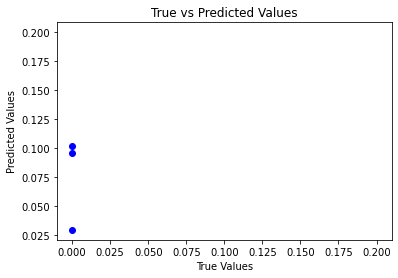

KeyError: 2

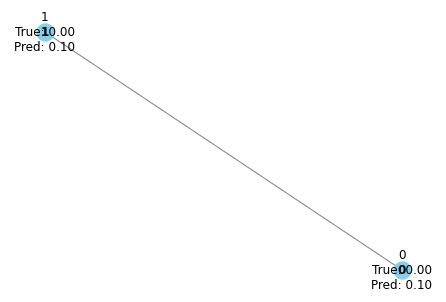

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualize the true values and predicted values
plt.scatter(test_data.y.numpy(), predictions, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

# Visualize the graph structure
def visualize_graph(data, predictions):
    edge_index = data.edge_index.numpy()
    G = nx.Graph()
    G.add_edges_from(edge_index.T)
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
    
    node_labels = {i: f"{i}\nTrue: {data.y[i]:.2f}\nPred: {predictions[i]:.2f}" for i in range(len(data.y))}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='black')

    plt.title('Graph Structure with Node Labels')
    plt.show()

# Visualize the graph structure with node labels
visualize_graph(test_data, predictions)
